#### Using a power flow, compute the maximum voltage rise on the on lower network from Jan-01-2020 to  June-01-2022.


The computed Voltage rise (Vrise) is converted into its binary counterpart.

See: 
- [VoltageRiseNum_Train](VoltageRiseNum_Train.ipynb) and [VoltageRiseNum_Pred](VoltageRiseNum_Pred.ipynb) for training and testing to predict numerical Voltage rise.
- [VoltageRiseBin_Train](voltageRiseBin_Train.ipynb) and [VoltageRiseBin_Pred](voltageRiseBin_Pred.ipynb) for training and testing to predict binary Voltage rise.


---

#### Import modules

In [8]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import ipyparallel as ipp
from tqdm import tqdm # Profiling 
import pickle 
import sys
import os
from pickle import load
import checker
import tensorflow as tf
import joblib

In [21]:
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import oriClass as oriCs
from fnfrnb import NotebookLoader
from oriVariables import (network_folder, 
                          testSet_end, 
                          defAuth_hvBus_vRiseMax, 
                          defAuth_hvBus_vRiseMin,
                          testSet_end,
                          h_start_end2,
                          lowerNet_file_loc, 
                          upperNet_file_loc, 
                          simResult_folder, 
                          ctrld_HvProd_name, 
                          default_ctrld_hvProd_max )

from fnfrnb import NotebookLoader

In [22]:
oriPar = NotebookLoader().load_module('parFn')

importing Jupyter notebook from parFn.ipynb


#### Import Networks


In [4]:
lowerNet=pp.from_pickle(lowerNet_file_loc)    # Import the Lower Network
upperNet=pp.from_pickle(upperNet_file_loc)    # Import the upper Network

# Load networks
networks = oriCs.InitNetworks(upperNet, lowerNet)

# To use later in functions 
sum_max_main_network = networks.get_upperNet_sum_max_lvProdLoad()

# Extract the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT = sum_max_main_network[0]
sum_max_p_mw_StLaurent_load = sum_max_main_network[1]

#### Import Cleaned data files for component of the network

In [9]:
df_data = joblib.load(simResult_folder+'StLaurent_cleanedData.pkl')

# Extract only daylight period i.e. from 07am to 7PM
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object)
                .between_time(*h_start_end2) ).index.to_period(pd_Δt)
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique pandas.DataFrame
df_data = df_data.loc[per_daylight]

# # Extract only the relevant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index < testSet_end]
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time(*h_start_end2) ).index.to_period(pd_Δt)


# Check whether the input dataframe columns are in the expected order
checker.check_networkDataDf_columnsOrder(df_final)

#### Data extraction on the network

In [10]:
lowerNet_hv_bus = networks.get_lowerNet_hv_bus_df() # Extract HV bus in the network

pp.runpp(lowerNet) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(lowerNet.res_bus.vm_pu[lowerNet.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = [i for i in activated_bus_index 
                               if i in lowerNet_hv_bus.index]

# redefine data given final pandas.DataFrame
df_prodHT = df_final.iloc[:,2:]
df_prod_bt_total = df_final.iloc[:,[1]]
df_cons_total = df_final.iloc[:,[0]]

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Start Parallel engines

In [11]:
n_engines = os.cpu_count() - 1  # Define total number of parallel engines to use. 
# Make sure it is lower than the total number of cores in the computer otherwise 
# no ressources is available to work when the simulation is running. 
parEngines = oriCs.CreateParEngines(n_engines)
                   

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

#### Load network

In [14]:
# Add a controllable line to the static generators
lowerNet.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
lowerNet.sgen['controllable'][lowerNet.sgen.name==ctrld_HvProd_name] = True

# Add Missing columns to be able to un an opf 
lowerNet.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
lowerNet.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

lowerNet.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
lowerNet_hv_bus = list(lowerNet.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(lowerNet) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(lowerNet.res_bus.vm_pu[lowerNet.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in lowerNet_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [15]:
vm_mu_max, vm_mu_min = defAuth_hvBus_vRiseMax, defAuth_hvBus_vRiseMin  
lowerNet.bus.max_vm_pu[lowerNet_hv_activated_bus] = vm_mu_max
lowerNet.bus.min_vm_pu[lowerNet_hv_activated_bus] = vm_mu_min

#### Define Cost 

In [16]:
# get the index of the controlled HV prod in SGEN table
ctrld_hvProd_index = lowerNet.sgen.query('name==@ctrld_HvProd_name').index

# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(lowerNet, ctrld_hvProd_index,'sgen', cp1_eur_per_mw=-1)

lowerNet.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Send data into local space of each engine

In [20]:
opf_status = False

# Create a dictionnary containing all the varible that will be used by each client or engine
pred_model = None

parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'vm_mu_max':vm_mu_max,
                        'pred_model':pred_model
                         })

# Declare variables
hvProd_upscaling_coef = default_ctrld_hvProd_max 
P0100_max = default_ctrld_hvProd_max

# Create dictionnary of main variable i.e. Prod BT, HT, Cons to used in parallel engines 
dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final,
                                                  networks, 
                                                  hvProd_upscaling_coef,
                                                  P0100_max )

df_prodHT = dict_df_sgenLoad['df_prodHT']


# Send all the created variables into local spaces of each engine.
parEngines.sendVar_to_localSpace(df_prodHT.index, opf_status, dict_df_sgenLoad, parameters_dict, True )


importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


#### Run Optimal /power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF/OPF -------------------  </span>**

In [23]:
pf_opf_block_result = oriPar.par_block_pfOpf(parEngines, pred_model)    


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

#### Binarize voltage rise on the Network

In [26]:
max_vm_pu_df = pf_opf_block_result

# Binarize : 0 ==>  v_rise < vm_mu_max
# Binarize : 0 ==>  v_rise >= vm_mu_max
bin_voltage_rise = [1 if cur_elm == True 
                    else 0 
                    for cur_elm in (max_vm_pu_df.max_vm_pu_pf > vm_mu_max).values ]

# Add new the binary V_rise column to max_vm_pu_df
max_vm_pu_df['Volt_Rise_Bin'] = bin_voltage_rise

#### Plot

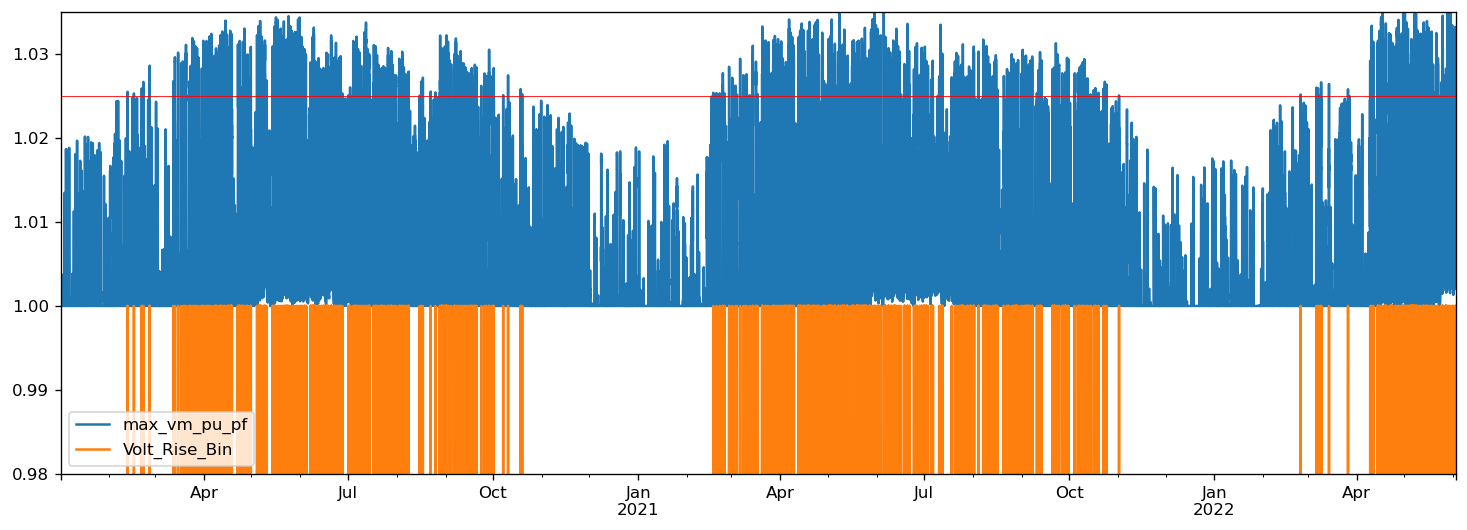

In [27]:
fig, axx = plt.subplots(figsize=(15,5), dpi=120)
max_vm_pu_df.plot(ax=axx)
plt.ylim((0.98,1.035))
plt.axhline(vm_mu_max, color='red', lw=0.5)

#### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [41]:
max_vm_pu_df.rename(columns={'vm_pu_max_pf':'known'}, inplace=True)# Rename columns
joblib.dump(max_vm_pu_df, f'{simResult_folder}Binary_Voltage_Rise.pkl')

['../Pickle_files/simulationResults/Binary_Voltage_Rise.pkl']